## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(5)

cv2.destroyAllWindows()

## Calculate the camera calibration coeffients

In [2]:
print(gray.shape[::-1])

(1280, 720)


In [3]:
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None) 

## Undistort images

In [4]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img,mtx,dist,None,mtx)

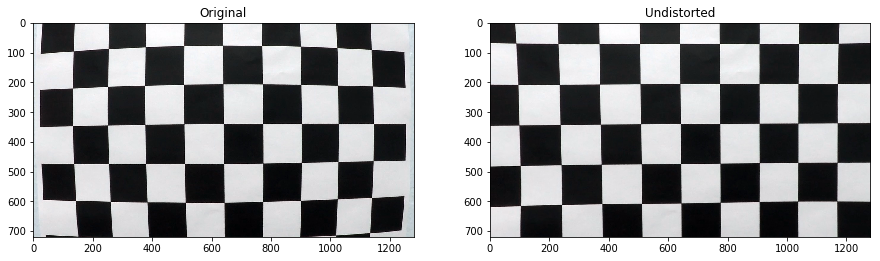

In [5]:
# test chessboard image undistortion
CB__test = cv2.imread('../camera_cal/calibration1.jpg')
undistorted_CB_test = undistort_img(CB__test, mtx, dist)
# display original and undistorted chessboard images
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.imshow(CB__test)
ax1.set_title('Original')
ax2.imshow(undistorted_CB_test)
ax2.set_title('Undistorted')

In [6]:
test_imgs1_path = glob.glob('../test_images/test*.jpg')
test_imgs2_path = glob.glob('../test_images/straight_lines*.jpg')
test_imgs_path = test_imgs1_path + test_imgs2_path
test_imgs = []
for i in range(len(test_imgs_path)):
    img = cv2.imread(test_imgs_path[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    test_imgs.append(img)

In [7]:
# show example 
import random
# generate random example imgages' ids
test_ids = random.sample(range(len(test_imgs)),4)
test_images = []
for img_id in test_ids:
    test_images.append(test_imgs[img_id])

undistorted_test_images = []

for img in test_images:
    undist_img = undistort_img(img, mtx, dist)
    undistorted_test_images.append(undist_img)

rows = 4
cols = 2

def showImgs(imgs, processed_imgs, rows, cols, cmap = None, title = ''):
    fig, axes = plt.subplots(rows, cols, figsize=(15,10))
    axes = axes.ravel()
    axes[0].set_title('Original')
    axes[1].set_title(title)
    for j in range(0,rows):
        img_index = j
        # plot original images in the odd number col and undistorted images in the even number col
        for i in range(cols):
            mod_i = i%cols
            index_ = j*cols + mod_i
            if mod_i == 0:
                image = imgs[img_index]
                #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                axes[index_].imshow(image, cmap=cmap)
            else:
                image = processed_imgs[img_index]
                axes[index_].imshow(image, cmap=cmap)


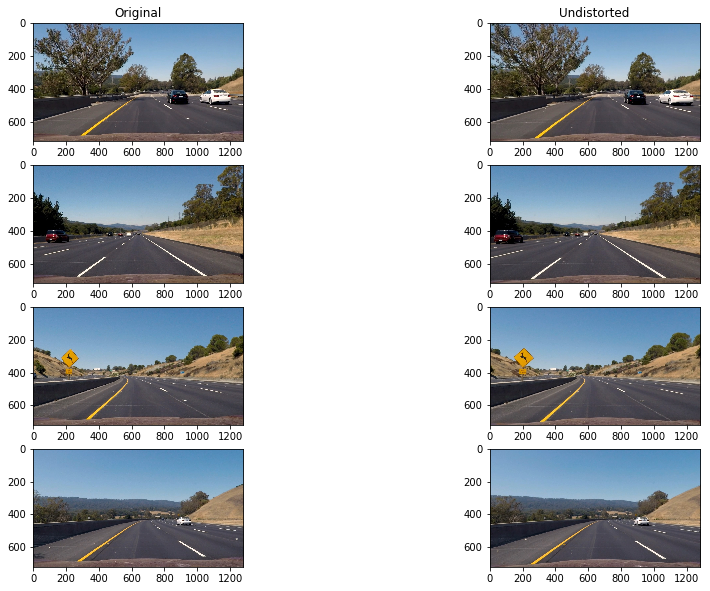

In [8]:
showImgs(test_images,undistorted_test_images, rows,cols, title = 'Undistorted')

## Apply gradients and color space transformation to create thresholded binary images

### Color space tranformation

In [9]:
# generate H-channel thresholded binary images in HLS 
def binary_H_thresholded(img, thresholds = (150,255)):
    # obtain S-channel image
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    # generate a binary image mask
    binary_img = np.zeros_like(H)
    # apply thresholds
    binary_img[(H > thresholds[0]) & (H <= thresholds[1])] = 1
    return binary_img

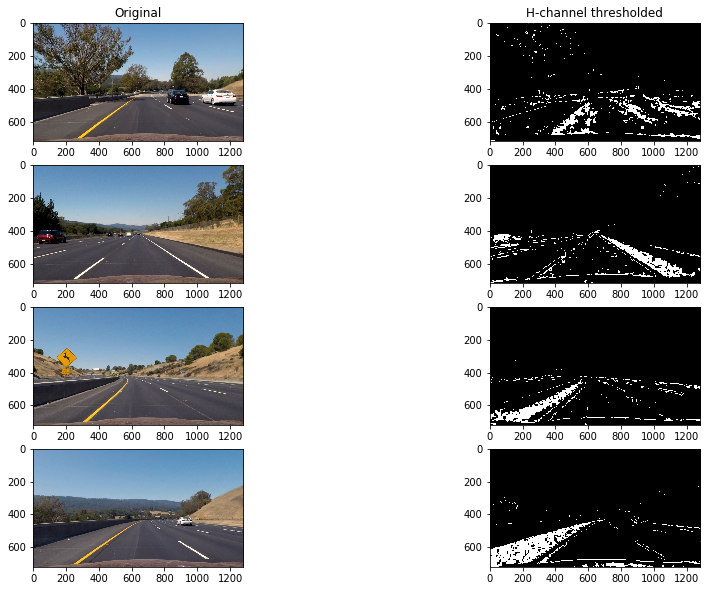

In [10]:
binary_H_imgs = []

for img in undistorted_test_images:
    binary_H_img = binary_H_thresholded(img)
    binary_H_imgs.append(binary_H_img)


showImgs(undistorted_test_images,binary_H_imgs, rows,cols, cmap = 'gray', title = 'H-channel thresholded')

In [11]:
# generate L-channel thresholded binary images in HLS 
def binary_L_thresholded(img, thresholds = (220,255)):
    # obtain S-channel image
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L = L*(255/np.max(L))
    # generate a binary image mask
    binary_img = np.zeros_like(L)
    # apply thresholds
    binary_img[(L > thresholds[0]) & (L <= thresholds[1])] = 1
    return binary_img

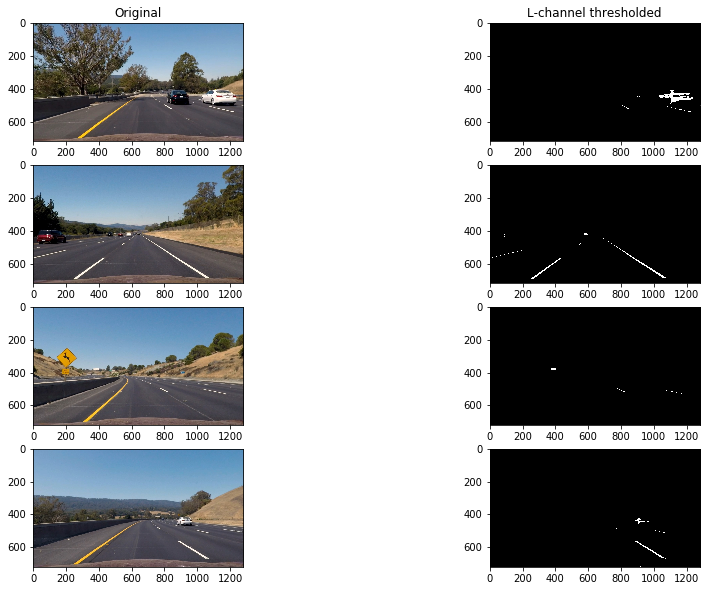

In [12]:
binary_L_imgs = []

for img in undistorted_test_images:
    binary_L_img = binary_L_thresholded(img)
    binary_L_imgs.append(binary_L_img)


showImgs(undistorted_test_images,binary_L_imgs, rows,cols, cmap = 'gray', title = 'L-channel thresholded')

In [13]:
# generate S-channel thresholded binary images in HLS 
def binary_S_thresholded(img, thresholds = (180,255)):
    # obtain S-channel image
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    # generate a binary image mask
    binary_img = np.zeros_like(S)
    # apply thresholds
    binary_img[(S > thresholds[0]) & (S <= thresholds[1])] = 1
    return binary_img

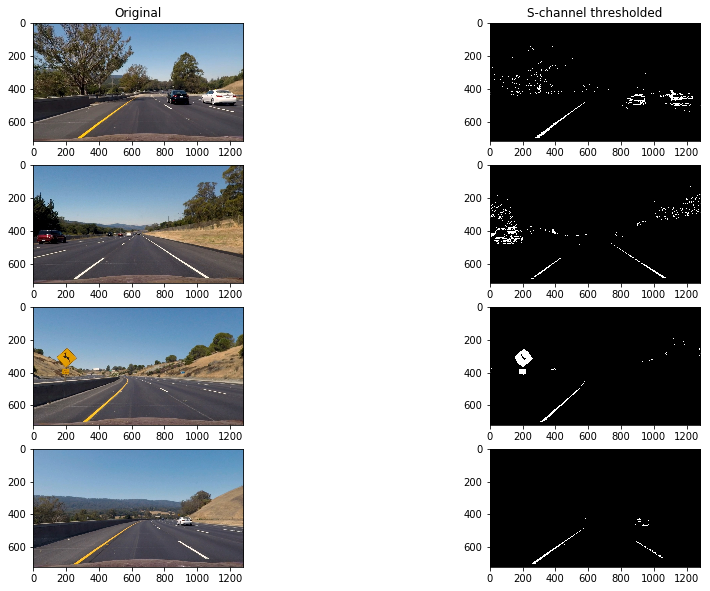

In [14]:
binary_S_imgs = []

for img in undistorted_test_images:
    binary_S_img = binary_S_thresholded(img)
    binary_S_imgs.append(binary_S_img)


showImgs(undistorted_test_images,binary_S_imgs, rows,cols, cmap = 'gray', title = 'S-channel thresholded')

In [15]:
# generate B-channel thresholded binary images in LAB 
def binary_B_thresholded(img, thresholds = (190,255)):
    # obtain B-channel image
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    B = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(B) > 175:
        B = B*(255/np.max(B))
    # generate a binary image mask
    binary_img = np.zeros_like(B)
    # apply thresholds
    binary_img[(B > thresholds[0]) & (B <= thresholds[1])] = 1
    return binary_img

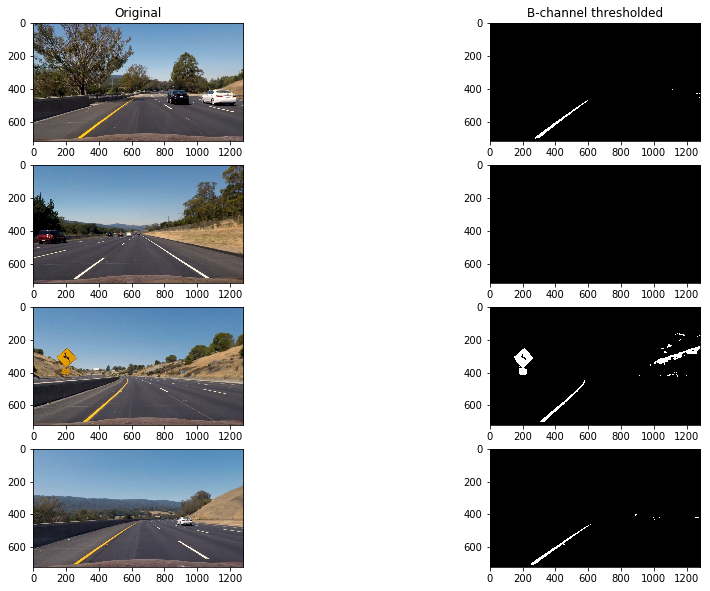

In [16]:
binary_B_imgs = []

for img in undistorted_test_images:
    binary_B_img = binary_B_thresholded(img)
    binary_B_imgs.append(binary_B_img)


showImgs(undistorted_test_images,binary_B_imgs, rows,cols, cmap = 'gray', title = 'B-channel thresholded')

### Gradient x and direction combining transformation

In [17]:
# generate gradient x and direction combining thresholded binary images
def binary_grad_x_dir_thresholded(img, thresholdsx = (25, 100), thresholdsdir = (0.7,1.2)):
    # grayscale images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calculate absolute sobel x and sobel y
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = 3)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = 3)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # scale to an 8-bit range (0-255)
    scaled_sobelx = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255 * abs_sobely/np.max(abs_sobely))
    # calculate the direction of gradient
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    # generate a binary mask
    binary_out = np.zeros_like(scaled_sobelx)
    binary_out[(scaled_sobelx > thresholdsx[0]) & (scaled_sobelx <= thresholdsx[1]) & \
               (dir_gradient > thresholdsdir[0]) & (dir_gradient <= thresholdsdir[1]) ] = 1
    return binary_out

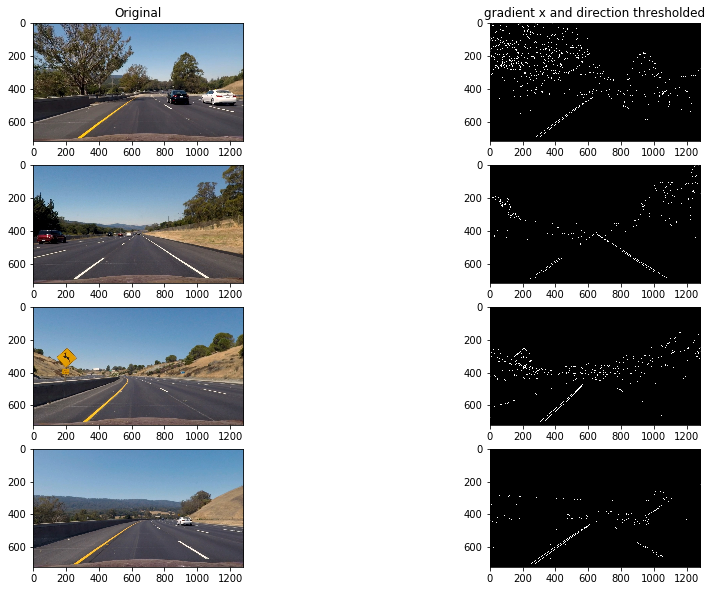

In [18]:
binary_x_dir_imgs = []

for img in undistorted_test_images:
    binary_x_dir_img = binary_grad_x_dir_thresholded(img)
    binary_x_dir_imgs.append(binary_x_dir_img)


showImgs(undistorted_test_images,binary_x_dir_imgs, rows,cols, cmap = 'gray', title = 'gradient x and direction thresholded')

### Gradient magnitute and direction combining transformation

In [19]:
# generate gradient mag and direction combining thresholded binary images
def binary_grad_mag_dir_thresholded(img, thresholdsmag = (50, 250), thresholdsdir = (0.7,1.2)):
    # grayscale images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calculate absolute sobel x and sobel y
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = 3)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = 3)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    mag = np.sqrt(sobelx**2 + sobely**2)
    # scale to an 8-bit range (0-255)
    scaled_mag = np.uint8(255 * mag/np.max(mag))
    # calculate the direction of gradient
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    # generate a binary mask
    binary_out = np.zeros_like(scaled_mag)
    binary_out[(scaled_mag > thresholdsmag[0]) & (scaled_mag <= thresholdsmag[1]) & \
               (dir_gradient > thresholdsdir[0]) & (dir_gradient <= thresholdsdir[1]) ] = 1
    return binary_out

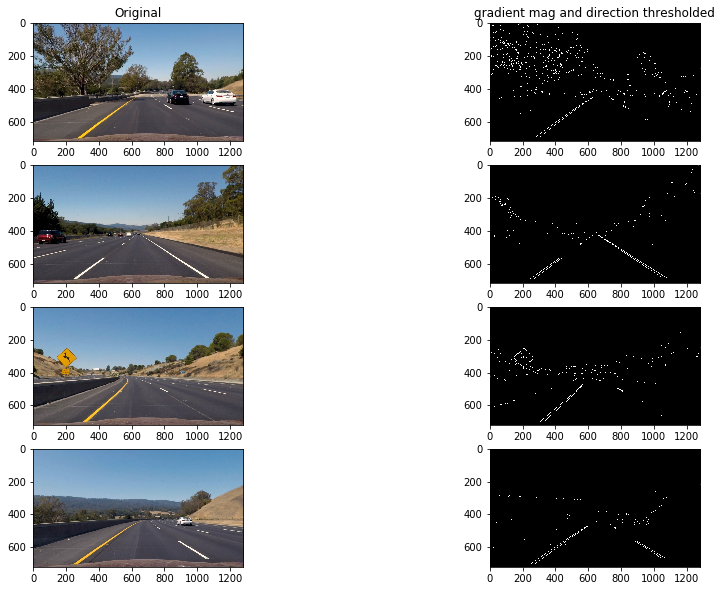

In [20]:
binary_mag_dir_imgs = []

for img in undistorted_test_images:
    binary_mag_dir_img = binary_grad_mag_dir_thresholded(img)
    binary_mag_dir_imgs.append(binary_mag_dir_img)


showImgs(undistorted_test_images,binary_mag_dir_imgs, rows,cols, cmap = 'gray', title = 'gradient mag and direction thresholded')

### Combining two binary images 

In [21]:
# combining different binary images
def comb_binary(binary_1, binary_2):

    binary_comb_img = np.zeros_like(binary_1)
    binary_comb_img[(binary_1 == 1) | (binary_2 == 1)] = 1

    return binary_comb_img

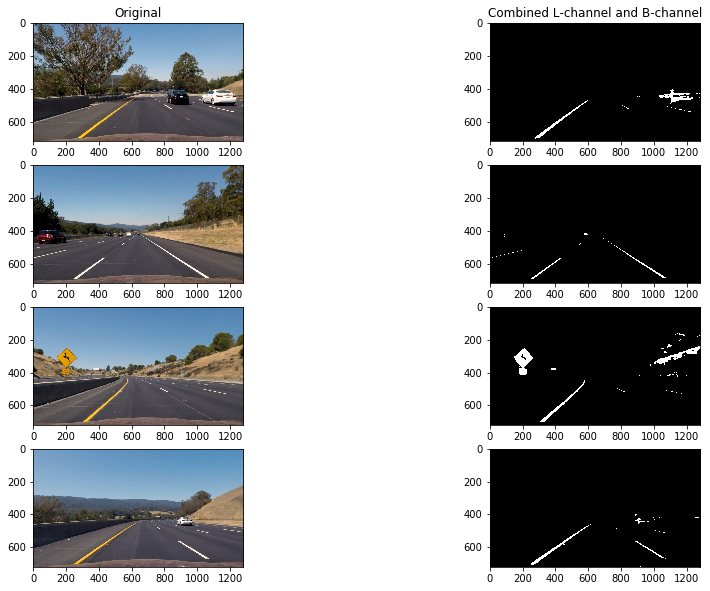

In [22]:
comb_binary_outputs = []

for img1, img2 in zip(binary_L_imgs,binary_B_imgs):
    comb_binary_img = comb_binary(img1, img2)
    comb_binary_outputs.append(comb_binary_img)

showImgs(undistorted_test_images,comb_binary_outputs, rows,cols, cmap = 'gray', title = 'Combined L-channel and B-channel')

## Apply perspective transform to binary images

In [23]:
# unwarp images using perspective transformation
def warp_imgs(img):
    img_size = (gray.shape[1], gray.shape[0])
    # define src and dst
    lt_pos = (585, 450) # left top position
    lb_pos = (190, 683) # left bottom position
    rt_pos = (700, 450) # right top position
    rb_pos = (1120, 683) # right bottom position
  
    src = np.float32([[lt_pos[0], lt_pos[1]], 
                      [rt_pos[0], rt_pos[1]],
                      [lb_pos[0], lb_pos[1]], 
                      [rb_pos[0], rb_pos[1]]])
        
    offset = 200
    dst = np.float32([[offset, 0],
                      [img_size[0]-offset, 0],
                      [offset, img_size[1]],
                      [img_size[0]-offset, img_size[1]]])

    
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img, M, M_inv

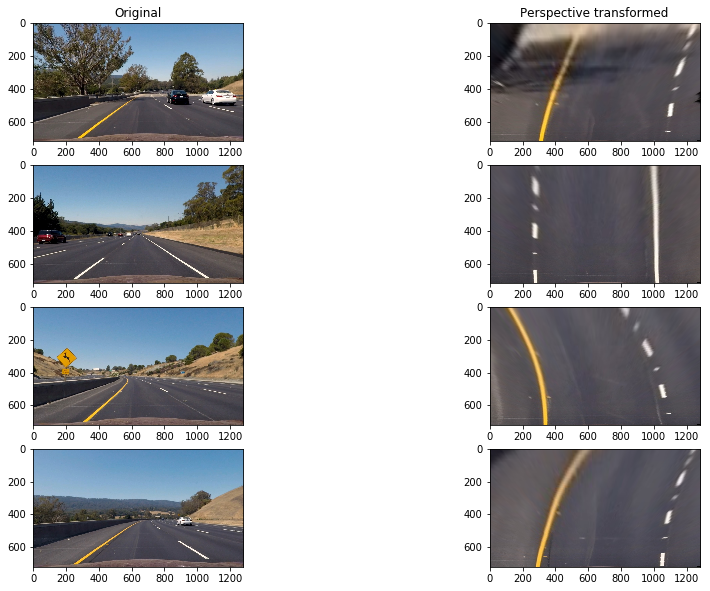

In [24]:
warped_imgs = []

for img in undistorted_test_images:
    warped_img, _, _ = warp_imgs(img)
    warped_imgs.append(warped_img)


showImgs(undistorted_test_images,warped_imgs, rows,cols, cmap = 'gray', title = 'Perspective transformed')

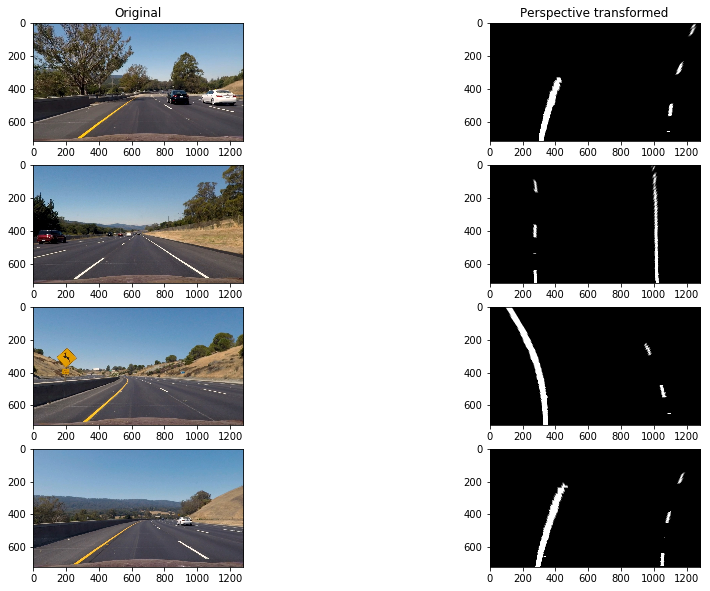

In [25]:
warped_imgs = []

for img in comb_binary_outputs:
    warp_img, _, _ = warp_imgs(img)
    warped_imgs.append(warp_img)

showImgs(undistorted_test_images,warped_imgs, rows,cols, cmap = 'gray', title = 'Perspective transformed')

## Define image processing pipeline

In [26]:
# define the complete image processing pipeline
def img_proc_pipeline(img):
    # undistort image
    undist_img = undistort_img(img, mtx, dist)
    # binary B-channel of undistort_img
    binary_B_img = binary_B_thresholded(undist_img)
    # binary L-channel of undistort_img
    binary_L_img = binary_L_thresholded(undist_img)
    # combine B-channel and L-channel
    comb_binary_img = comb_binary(binary_B_img, binary_L_img)
    # warp combined binary image
    warped_comb_img, M, M_inv = warp_imgs(comb_binary_img)
    
    return warped_comb_img, M_inv

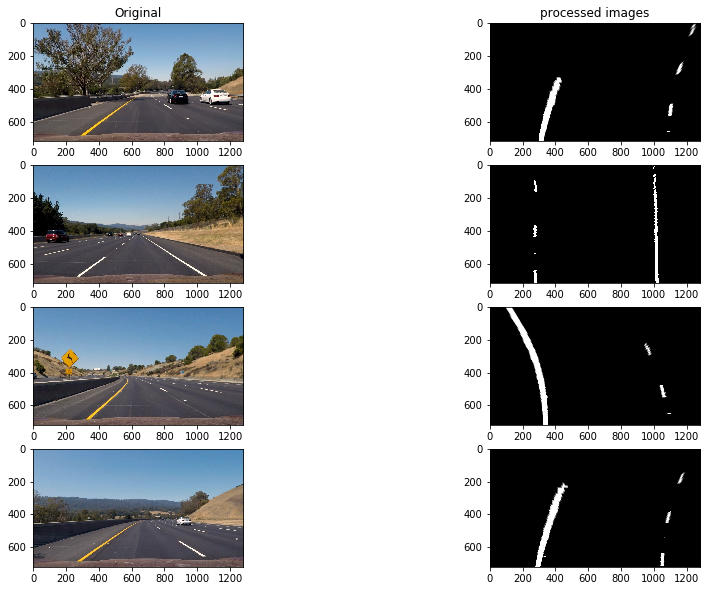

In [27]:
# show pipeline results                  
imgs_processed = []
for image in test_images:
    
    img_processed, _ = img_proc_pipeline(image)
    imgs_processed.append(img_processed)
    
showImgs(test_images, imgs_processed, rows=4, cols=2, cmap='gray',title='processed images')

## Detect lane pixels and plot the lane boundary

In [28]:
# define conversions in x and y from pixels space to meters
xm_per_pix = 3.7/750 # 12pt = 3.7m
ym_per_pix = 3.048/100  # 10pt = 3.048m

# use some parts of lecture codes here
def detect_lines(warped_binary_img, num_window = 10, window_width = 200):
    image_height = warped_binary_img.shape[0]
    window_height = np.int(image_height//num_window)
    # take a histogram of the bottom half of the image
    hist = np.sum(warped_binary_img[image_height//2:,:], axis = 0)
    # creat an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((warped_binary_img, warped_binary_img, warped_binary_img))*255)
    # find the peak of the left and right halves of the histogram
    # theses will be the starting point for the left and right lines
    midpoint = np.int(hist.shape[0]//2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # set margin to be half of the window width
    margin = window_width // 2;
    # set minimum number of pixels found to the recenter window
    minpix = 50
    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangle_data = []
    # step through the windows one by one
    for window in range(num_window):
        # identify window boundaries in x and y for both right and left lanes
        win_y_low = image_height - (window+1)*window_height
        win_y_high = win_y_low + window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low =  rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, \
                               win_xright_low, win_xright_high))
        # draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), \
                     (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), \
                     (0,255,0), 2)
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # if found pixels > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # fit a second order polynomial to each in meters
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, left_fit_m, right_fit_m, out_img, left_lane_inds, right_lane_inds, rectangle_data

In [29]:
# visualize detected lanes
def visualizeLanes(warped_binary_img):
    left_fit, right_fit, _, _, out_img, left_lane_inds, right_lane_inds, rectangle_data = \
    detect_lines(warped_binary_img)
    out_img2 = np.uint8(np.dstack((warped_binary_img, warped_binary_img, warped_binary_img)) *255)
    margin = 100
    # visualize with window box
    ploty = np.linspace(0, warped_binary_img.shape[0]-1, warped_binary_img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    nonzero = warped_binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # visualize with filled window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
    
    return out_img, result, left_fitx, right_fitx, ploty

### Visualize examples

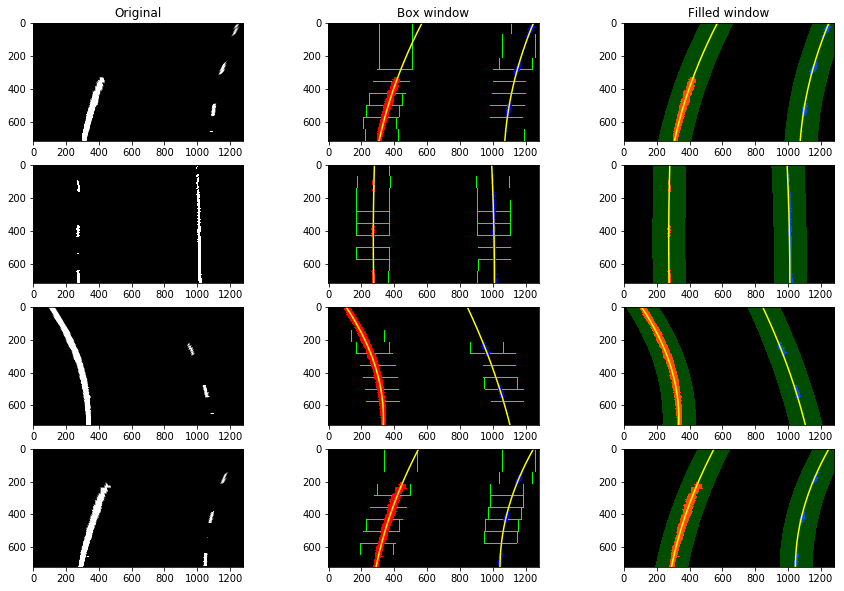

In [30]:
box_imgs = []
filled_imgs = []
left_fitxs = [] 
right_fitxs = []
for img in imgs_processed:
    box_img, filled_img,left_fitx, right_fitx, ploty = visualizeLanes(img)
    box_imgs.append(box_img)
    filled_imgs.append(filled_img)
    left_fitxs.append(left_fitx)
    right_fitxs.append(right_fitx)

# show visualized resulted
fig, axes = plt.subplots(4, 3, figsize=(15,10))
axes = axes.ravel()
axes[0].set_title('Original')
axes[1].set_title('Box window')
axes[2].set_title('Filled window')

for j in range(4):
    img_index = j
    # plot original images in the odd number col and undistorted images in the even number col
    for i in range(3):
        mod_i = i%3
        index_ = j*3 + mod_i
        if mod_i == 0:
            image = imgs_processed[img_index]
            #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            axes[index_].imshow(image, cmap='gray')
        elif mod_i == 1:
            image = box_imgs[img_index]
            axes[index_].imshow(image)
            axes[index_].plot(left_fitxs[img_index], ploty, color='yellow')
            axes[index_].plot(right_fitxs[img_index], ploty, color='yellow')
        else:
            image = filled_imgs[img_index]
            axes[index_].imshow(image)
            axes[index_].plot(left_fitxs[img_index], ploty, color='yellow')
            axes[index_].plot(right_fitxs[img_index], ploty, color='yellow')


### Determine the curvature of the lane and vehicle relative position to lane center

In [31]:
def calculateCurv(yRange, left_fit, right_fit_m):
    left_Curvature = np.float32(((1 + (2*left_fit_m[0]*yRange + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])/1000)
    right_Curvature = np.float32(((1 + (2*right_fit_m[0]*yRange + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])/1000)
    return left_Curvature, right_Curvature

In [32]:
def center_dist(xMax, yMax, left_fit_m, right_fit_m):
    veh_position = xMax/2
    Left_line = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    Right_line = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    Middle_of_line = Left_line + (Right_line - Left_line)/2
    diff = veh_position - Middle_of_line
    if diff < 0:
        msg = 'Vehicle is {:.2f} m left of center.'.format(-diff)
    else:
        msg = 'Vehicle is {:.2f} m right of center.'.format(diff)
    
    return msg

In [33]:
for img in imgs_processed:
    _, _, left_fit_m, right_fit_m, _, _, _, _ = detect_lines(img)
    xMax = img.shape[1] * xm_per_pix
    yMax = img.shape[0] * ym_per_pix
    msg = center_dist(xMax, yMax, left_fit_m, right_fit_m)
    left_Curvature, right_Curvature = calculateCurv(yMax, left_fit_m, right_fit_m)
    lane_Curvature = (left_Curvature+right_Curvature)/2
    print('Lane curvature: {:.2f} km. {}'.format(lane_Curvature, msg))

Lane curvature: 0.42 km. Vehicle is 0.25 m left of center.
Lane curvature: 2.90 km. Vehicle is 0.01 m left of center.
Lane curvature: 0.40 km. Vehicle is 0.39 m left of center.
Lane curvature: 0.33 km. Vehicle is 0.13 m left of center.


## Draw lane and its boundaries, then warp back onto the original image

In [34]:
# define draw lane
def draw_lane(undistorted_original_img,warped_binary,left_fit, right_fit, M_inv):
    new_img = np.copy(undistorted_original_img)
    
    # create an image to draw lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    warp_color = np.dstack((warp_zero,warp_zero,warp_zero))
    
    height,width = warped_binary.shape
    ploty = np.linspace(0,height-1,height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # recast the x and y points for cv2.fillPoly()
    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left, points_right))
    
    # draw lane on to warp_color
    cv2.fillPoly(warp_color, np.int_([points]), (0,255, 0))
    cv2.polylines(warp_color, np.int32([points_left]), isClosed=False, color=(225,0,255), thickness=30)
    cv2.polylines(warp_color, np.int32([points_right]), isClosed=False, color=(225,0,255), thickness=30)

    
    # warp back warp_color
    newwarp = cv2.warpPerspective(warp_color, M_inv, (width,height))
    # combine warp_color with original image
    final_img = cv2.addWeighted(new_img,1,newwarp,0.5,0)
    return final_img

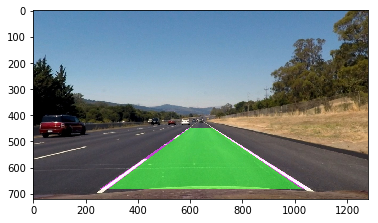

In [35]:
test_img = test_images[1]
warped_binary, M_inv = img_proc_pipeline(test_img)
left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _ = detect_lines(warped_binary)
test_img = undistort_img(test_img, mtx, dist)         
final_test_img = draw_lane(test_img,warped_binary,left_fit, right_fit, M_inv)
plt.imshow(final_test_img)

## Draw data on the original image

In [36]:
def draw_data(original_img, left_curvature, right_curvature, msg):
    new_img = np.copy(original_img)
    lane_Curvature = (left_curvature+right_curvature)/2
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Lane curvature: {:.2f} km.'.format(lane_Curvature)
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    text = msg
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

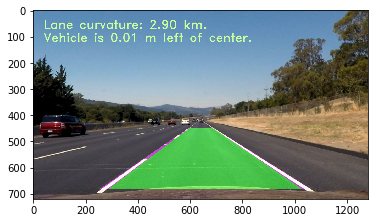

In [37]:
test_img = test_images[1]
binary_test_img, _ = img_proc_pipeline(test_img)
_, _, left_fit_m, right_fit_m, _, _, _, _ = detect_lines(binary_test_img)
xMax = binary_test_img.shape[1] * xm_per_pix
yMax = binary_test_img.shape[0] * ym_per_pix
msg = center_dist(xMax, yMax, left_fit_m, right_fit_m)
left_Curvature, right_Curvature = calculateCurv(yMax, left_fit_m, right_fit_m)
texted_final_test_img = draw_data(final_test_img,left_Curvature, right_Curvature,msg )
plt.imshow(texted_final_test_img)

## Vedio pipeline

In [40]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.left_curvature = None
        self.right_curvature = None
def videoPipeline(inputVideo, outputVideo):
    myclip = VideoFileClip(inputVideo)
    leftLane = Lane()
    rightLane = Lane()
    
    def whole_img_process(img):
        xm_per_pix = 3.7/750
        ym_per_pix = 3.048/100
        # processing image  to a warped binary image
        processed_img, M_inv = img_proc_pipeline(img)
        # detect lanes
        left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _ = detect_lines(processed_img)
        # calculate lane information data
        yRange = processed_img.shape[0]-1
        xMax = processed_img.shape[1] * xm_per_pix
        yMax = processed_img.shape[0] * ym_per_pix
        msg = center_dist(xMax, yMax, left_fit_m, right_fit_m)
        left_Curvature, right_Curvature = calculateCurv(yMax, left_fit_m, right_fit_m)
        
        if left_Curvature > 5000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            left_Curvature = leftLane.left_curvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.left_curvature = left_Curvature
        
        if right_Curvature > 5000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            right_Curvature = rightLane.right_curvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.right_curvature = right_Curvature
        
        # draw lanes
        img = undistort_img(img,mtx,dist)
        lane_drawn_img = draw_lane(img,processed_img,left_fit, right_fit, M_inv)
        # draw data
        final_img = draw_data(lane_drawn_img,left_Curvature, right_Curvature,msg)
        
        return final_img
    clip = myclip.fl_image(whole_img_process)
    clip.write_videofile(outputVideo, audio=False)

In [41]:
# Project video
videoPipeline('../project_video.mp4', 'project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  2%|▏         | 19/1261 [00:03<03:43,  5.56it/s]

KeyboardInterrupt: 